In [1]:
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.campus_env_compact import CampusEnv
from lib import plotting

matplotlib.style.use('ggplot')

env = CampusEnv()


getting states list
finish init


In [2]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [3]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.1, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.nA))

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.nA)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Implement this!
        # Reset the environment and pick the first action
        #YOU HAVE TO REWRITE THIS, OTHERWISE IT WILL GET RID OF ALL STUDENTS
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            #print("----------")
            #print(action, "action")
            #print(reward, "reward")
            #print(next_state, "next_state")
            
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
            
            state = next_state
            #print(state)
    return Q, stats


Episode 2000/2000.

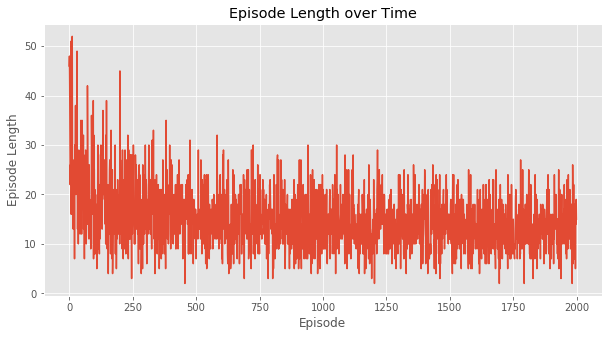

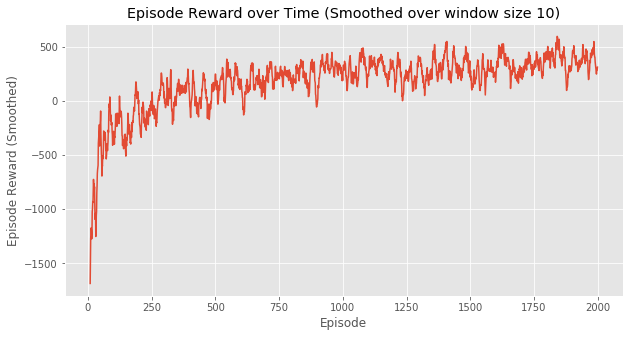

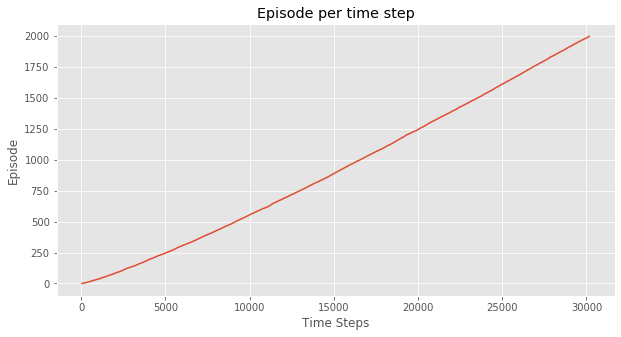

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [4]:
Q, stats = q_learning(env, 2000)

plotting.plot_episode_stats(stats)

In [72]:
policy_output = np.array(list(Q.items()))

In [143]:
import torch
from torch import nn
from torch import optim
from matplotlib.pyplot import *

In [204]:
X_input = []
Y_output = []
for i in range(len(policy_output)):
    X_input.append(list(map(float, policy_output[i][0].split(','))))
    Y_output.append(list(map(float, policy_output[i][1])))

In [205]:
X_input = torch.tensor(X_input)
Y_output = torch.tensor(Y_output)

In [206]:
X_input

tensor([[1., 2., 0.,  ..., 0., 3., 5.],
        [0., 2., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 1.,  ..., 0., 1., 0.],
        [2., 0., 5.,  ..., 3., 0., 2.],
        [1., 0., 5.,  ..., 3., 0., 1.]])

In [207]:
Y_output = ((Y_output)-torch.min(Y_output))/(torch.max(Y_output) - torch.min(Y_output))
#Y_output = ((Y_output)-torch.mean(Y_output))/torch.std(Y_output)

In [208]:
Y_output[1]

tensor([0.3940, 0.6107, 0.4486, 0.4486, 0.4486, 0.4486])

In [209]:
inputLayerSize, hiddenLayerSize, outputLayerSize = 8, 10,6

model = nn.Sequential(nn.Linear(inputLayerSize, hiddenLayerSize),
                       nn.Linear(hiddenLayerSize, outputLayerSize),
            )

In [210]:
from IPython import display

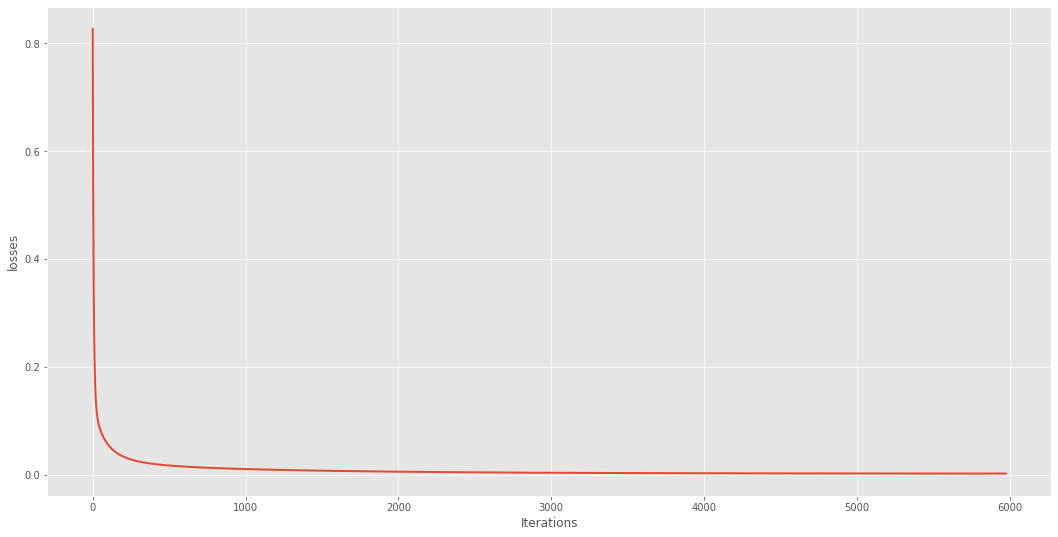

<Figure size 432x288 with 0 Axes>

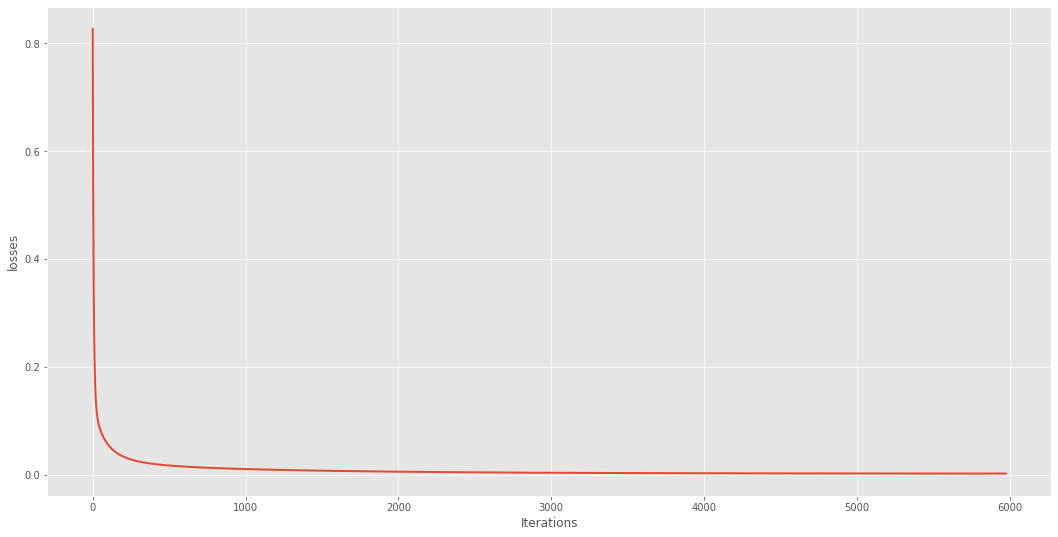

In [211]:
num_iterations = 6000; lr = 1e-2; losses = []
criterion = nn.MSELoss()

opt = optim.SGD(model.parameters(), lr=lr) #pass in the parameters we want to optimize. 
for i in range(num_iterations):
    yhat = model(X_input)
    #loss = torch.sum(0.5*(Y_output-yhat)**2)  Why the hell this does not work????????????????????????
    loss = criterion(Y_output, yhat)
    loss.backward() #Compute Gradients
    
    opt.step() #Take a gradient descent "step", note that we no longer need torch.no_grad() here.
    opt.zero_grad()
    losses.append(loss.item())
    if i%25==0:
        clf(); fig = figure(0, (18, 9))
        plot(losses, linewidth = 2)
        xlabel('Iterations'); ylabel('losses')
        display.clear_output(wait=True); display.display(gcf())

In [212]:
#fig = figure(0, (12,6))
#plot(losses, linewidth = 3); grid(1); xlabel('iterations'); ylabel('loss');